# Imports
Run this block first to import all necessary libraries.

In [1]:
import numpy as np
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
from IPython.display import display
from PIL import Image as PilImage
import spacy
from timexy import Timexy
from wordcloud import WordCloud
from scipy.stats import mannwhitneyu

# Paths, Variables and Setup
Update paths to point to the correct files if necessary, update variables, and run the setup code blocks.

In [2]:
# Paths
DATASET = r"./data/dataset.csv"
DATA_SOURCE = r"./data/source_data.csv"

In [3]:
# Variables
classes = ["No time-sensitive information", "Less than one minute", "1-5 minutes", "5-15 minutes", "15-45 minutes",
           "45 minutes - 2 hours", "2-6 hours", "More than 6 hours", "1-3 days", "3-7 days", "1-4 weeks",
           "More than one month"]

In [4]:
# Setup: spaCy model
# For this to work, en_core_web_sm must be installed locally (use the command below on first execution)
# python -m spacy download en_core_web_sm
nlp = spacy.load("en_core_web_sm")
# Add "timexy" component to the spacy pipeline, which will detect temporal expressions. This requires the timexy import.
nlp.add_pipe("timexy", config= {
    "kb_id_type": "timex3",
    "label": "timexy",
    "overwrite": False
}, before="ner")

In [5]:
# Setup: Function for mapping a sentence to its rough word count (split by spaces)
def avg_word(sentence):
    words = sentence.split()
    return len(words)

In [6]:
# Setup: Function that executes a two-sided Mann-Whitney U test on all pairs in a list of sets
def mann_whitney_u_test(sets, names):
    tests = [(sets[i], sets[j], names[i], names[j]) for i in range(len(sets)) for j in range(i+1, len(sets))]
    for set1, set2, name1, name2 in tests:
        print(f"Testing {name1} vs. {name2}:")
        print(f"p-value: {mannwhitneyu(set1, set2, alternative='two-sided').pvalue}")

In [7]:
# Setup: Function for lemmatizing and normalizing a text (lowercase, no stopwords, no punctuation, no spaces)
def lemmatize(text, pipeline):
    tokens = pipeline(text)
    tokens = [token.lemma_.lower() for token in tokens if not token.is_stop and not token.is_punct and not token.is_space]
    return tokens

In [8]:
# Setup: Function for displaying a wordcloud
def display_wordcloud(cloud):
    wordcloud_array = np.array(cloud.to_image())
    pil_img = PilImage.fromarray(wordcloud_array)
    display(pil_img)

In [9]:
# Setup: Function that returns the difference of g-test likelihoods for a word in two corpora
def g_test_modified(word, c1, c2):
    # Get the size of the corpora
    c1_size = sum(c1.values())
    c2_size = sum(c2.values())
    # Get the observed counts
    c1_observed = c1.get(word, 0)
    c2_observed = c2.get(word, 0)
    # Expected count
    c1_expected = c1_size * (c1_observed + c2_observed) / (c1_size + c2_size)
    c2_expected = c2_size * (c1_observed + c2_observed) / (c1_size + c2_size)
    # Calculate the likelihood
    likelihood_c1 = c1_observed * np.log(c1_observed / c1_expected) if c1_observed > 0 else 0
    likelihood_c2 = c2_observed * np.log(c2_observed / c2_expected) if c2_observed > 0 else 0
    # We return the difference between the likelihoods to see which corpus the word is more likely to appear in.
    return likelihood_c1 - likelihood_c2

In [10]:
# Setup: Function that calculates the keyness of common words in two corpora
def calculate_keyness(corpus1_counts, corpus2_counts):
    # Get the words that appear in each corpus at least five times
    words = set(corpus1_counts.keys()).intersection(set(corpus2_counts.keys()))
    words = [word for word in words if corpus1_counts[word] >= 5 and corpus2_counts[word] >= 5]
    keyness_values = {}

    for word in words:
        keyness_values[word] = g_test_modified(word, corpus1_counts, corpus2_counts)

    # Get dataframe of keyness values
    keyness_df = pd.DataFrame.from_dict(keyness_values, orient='index', columns=['keyness'])
    keyness_df = keyness_df.sort_values(by=['keyness'], ascending=False)
    keyness_df = keyness_df.reset_index().rename(columns={'index': 'word'})

    return keyness_df

# Notebook Summary
This notebook contains a quantitative analysis of the generated dataset, including text length, content, class distribution, and temporal expressions. A likelihood-ratio test is used to determine which words are most likely to appear in tweets with a certain temporal validity period. The Mann-Whitney-U test is used to determine whether the distribution of character- and word-count is significantly different between the classes.

# 1. Import Dataset
We load the fully created dataset and merge it with the source candidates (containing the tweet IDs).

In [11]:
dataset = pd.read_csv(DATASET)
print(f"Loaded {len(dataset)} sentence pairs.")

Loaded 5055 sentence pairs.


In [12]:
# Create subsets based on change label
dataset_decreased = dataset[dataset["change"] == "decreased"]
dataset_neutral = dataset[dataset["change"] == "neutral"]
dataset_increased = dataset[dataset["change"] == "increased"]
assert len(dataset_decreased) == len(dataset_neutral) == len(dataset_increased) == len(dataset)/3

# 2. Content Analysis: Class Distribution
We analyze the distribution of the classes in the dataset, both for the expected lifetime of tweets and the updated lifetimes.

In [13]:
# Bar chart of the class distribution (expected)
fig = px.bar((dataset["context_only_tv"].rename("Target Statements").value_counts() / 3).rename({i: cls for i, cls in enumerate(classes)}), title="Class Distribution (Expected Temporal Validity)", category_orders={"index": classes}, template="plotly_white", labels={"index": "Class", "value": "Count"}, width=800, height=600)
fig.update_layout(showlegend=False)
fig.show()

In [14]:
# Bar chart of the class distribution (decreased)
fig = px.bar(dataset_decreased["combined_tv"].rename("Decreased Follow-Ups").value_counts().rename({i: cls for i, cls in enumerate(classes)}), title="Class Distribution (Decreased Temporal Validity)", category_orders={"index": classes}, template="plotly_white", labels={"index": "Class", "value": "Count"}, width=800, height=600)
fig.update_layout(showlegend=False)
fig.show()

In [15]:
# Bar chart of the class distribution (increased)
fig = px.bar(dataset_increased["combined_tv"].rename("Increased Follow-Ups").value_counts().rename({i: cls for i, cls in enumerate(classes)}), title="Class Distribution (Increased Temporal Validity)", category_orders={"index": classes}, template="plotly_white", labels={"index": "Class", "value": "Count"}, width=800, height=600)
fig.update_layout(showlegend=False)
fig.show()

In [16]:
# Bar chart of the difference between expected and decreased lifetime
decreased_diff = dataset_decreased["context_only_tv"] - dataset_decreased["combined_tv"]
fig = px.bar(decreased_diff.rename("Change Delta (Decreased)").value_counts(), title="Temporal Validity Change Delta (Decreased Temporal Validity)", template="plotly_white", labels={"index": "Class Distance from Target Statement", "value": "Count"}, width=800, height=600)
fig.update_layout(showlegend=False)
fig.show()

In [17]:
# Bar chart of the difference between expected and increased lifetime
increased_diff = dataset_increased["combined_tv"] - dataset_increased["context_only_tv"]
fig = px.bar(increased_diff.rename("Change Delta (Increased)").value_counts(), title="Temporal Validity Change Delta (Increased Temporal Validity)", template="plotly_white", labels={"index": "Class Distance from Target Statement", "value": "Count"}, width=800, height=600)
fig.update_layout(showlegend=False)
fig.show()

In [18]:
# Show both differences in one chart
# Create dataframes with the counts and a new column to identify the type of difference
increase_diff_counts = increased_diff.value_counts().reset_index().rename(columns={'index': 'class', 0: 'count'})
increase_diff_counts['diff_type'] = 'Increased TV'
decrease_diff_counts = decreased_diff.value_counts().reset_index().rename(columns={'index': 'class', 0: 'count'})
decrease_diff_counts['diff_type'] = 'Decreased TV'
# negate the class values for the decrease_diff_counts
decrease_diff_counts['class'] = decrease_diff_counts['class'] * -1
# Combine the dataframes
combined_diff_counts = pd.concat([increase_diff_counts, decrease_diff_counts], ignore_index=True)
# Create the bar chart
fig = px.bar(combined_diff_counts, x='class', y='count', color='diff_type', title="Temporal Validity Change Delta", labels={'class': 'Temporal Validity Delta (Class Distance From Target Statement)', 'count': 'Count', 'diff_type': 'Follow-Up Statement Type'}, template="plotly_white", width=800, height=600)
fig.show()

# 3. Content Analysis: Tweet Length
We analyze the distribution of the tweet lengths in the dataset, both for the baseline tweets as well as generated tweets.
We hypothesize that tweet length could make it trivial for models to distinguish "unchanged TV" follow-up tweets from those that change the temporal validity.

In [19]:
# Boxplot of the tweet lengths of "original", "decrease", "increase" and "unchanged" tweets.
fig = go.Figure()
fig.add_trace(go.Box(y=dataset_decreased["context"].map(len), name="Target"))
fig.add_trace(go.Box(y=dataset_decreased["follow_up"].map(len), name="Decreased TV"))
fig.add_trace(go.Box(y=dataset_neutral["follow_up"].map(len), name="Unchanged TV"))
fig.add_trace(go.Box(y=dataset_increased["follow_up"].map(len), name="Increased TV"))
fig.update_layout(title="Character Length of Statements", yaxis_title="Statement Length")
fig.update_layout(width=800, height=600)
fig.update_layout(template="plotly_white")
fig.show()

In [20]:
# Map the lengths of the tweets to lists
tweet_lengths_target = dataset_decreased["context"].map(len).tolist()
tweet_lengths_decreased = dataset_decreased["follow_up"].map(len).tolist()
tweet_lengths_neutral = dataset_neutral["follow_up"].map(len).tolist()
tweet_lengths_increased = dataset_increased["follow_up"].map(len).tolist()
tweet_lengths_all = tweet_lengths_target + tweet_lengths_decreased + tweet_lengths_neutral + tweet_lengths_increased
# Test all sets
mann_whitney_u_test([tweet_lengths_all, tweet_lengths_target, tweet_lengths_decreased, tweet_lengths_neutral, tweet_lengths_increased], ["All", "Target Statement", "Decreased TV", "Unchanged TV", "Increased TV"])

Testing All vs. Target Statement:
p-value: 0.0027732195436589754
Testing All vs. Decreased TV:
p-value: 9.95562957905235e-25
Testing All vs. Unchanged TV:
p-value: 1.1642950910648293e-211
Testing All vs. Increased TV:
p-value: 8.35538534706519e-71
Testing Target Statement vs. Decreased TV:
p-value: 6.317541412486891e-08
Testing Target Statement vs. Unchanged TV:
p-value: 8.924290206351831e-148
Testing Target Statement vs. Increased TV:
p-value: 3.1203406605860968e-28
Testing Decreased TV vs. Unchanged TV:
p-value: 6.742798865683205e-246
Testing Decreased TV vs. Increased TV:
p-value: 1.2279695756650488e-10
Testing Unchanged TV vs. Increased TV:
p-value: 0.0


In [21]:
# Map the word count of tweets to lists
avg_wordcount_target = dataset_neutral['context'].apply(lambda x: avg_word(x)).tolist()
avg_wordcount_decreased = dataset_decreased['follow_up'].apply(lambda x: avg_word(x)).tolist()
avg_wordcount_neutral = dataset_neutral['follow_up'].apply(lambda x: avg_word(x)).tolist()
avg_wordcount_increased = dataset_increased['follow_up'].apply(lambda x: avg_word(x)).tolist()
avg_wordcount_all = avg_wordcount_target + avg_wordcount_decreased + avg_wordcount_neutral + avg_wordcount_increased

# Test all sets
mann_whitney_u_test([avg_wordcount_all, avg_wordcount_target, avg_wordcount_decreased, avg_wordcount_neutral, avg_wordcount_increased], ["All", "Target Statement", "Decreased TV", "Unchanged TV", "Increased TV"])

Testing All vs. Target Statement:
p-value: 2.3324600682360017e-06
Testing All vs. Decreased TV:
p-value: 9.636238635377633e-26
Testing All vs. Unchanged TV:
p-value: 1.4484532760393394e-222
Testing All vs. Increased TV:
p-value: 4.184626668947339e-62
Testing Target Statement vs. Decreased TV:
p-value: 1.368313777922775e-05
Testing Target Statement vs. Unchanged TV:
p-value: 6.3903342816250885e-177
Testing Target Statement vs. Increased TV:
p-value: 1.2861615262358243e-19
Testing Decreased TV vs. Unchanged TV:
p-value: 2.5956410634744034e-253
Testing Decreased TV vs. Increased TV:
p-value: 2.3833074113023376e-07
Testing Unchanged TV vs. Increased TV:
p-value: 0.0


In [22]:
np_target = np.array(avg_wordcount_target)
np_decreased = np.array(avg_wordcount_decreased)
np_neutral = np.array(avg_wordcount_neutral)
np_increased = np.array(avg_wordcount_increased)
np_followup = np.array(avg_wordcount_decreased + avg_wordcount_neutral + avg_wordcount_increased)

# Create a table of average word count and variance
wordcount_table = pd.DataFrame({'Target': [np_target.mean(), np_target.var()], 'Follow-Up': [np_followup.mean(), np_followup.var()], 'Decreased TV': [np_decreased.mean(), np_decreased.var()], 'Unchanged TV': [np_neutral.mean(), np_neutral.var()], 'Increased TV': [np_increased.mean(), np_increased.var()]}, index=['Mean', 'Variance'])
# round to 1 decimal place
wordcount_table = wordcount_table.round(1)
wordcount_table

Target  Follow-Up  Decreased TV  Unchanged TV  Increased TV
Mean        16.1       14.6          16.6           9.8          17.5
Variance    52.2       38.7          34.9          15.4          30.6

# 4. Content Analysis: Tweet Content
We analyze the content of the tweets in the dataset.
We find frequent words and bigrams in each set of tweets and evaluate the term keyness in each set.

We first create wordclouds of the tweets in the dataset to get a general overview of the content.

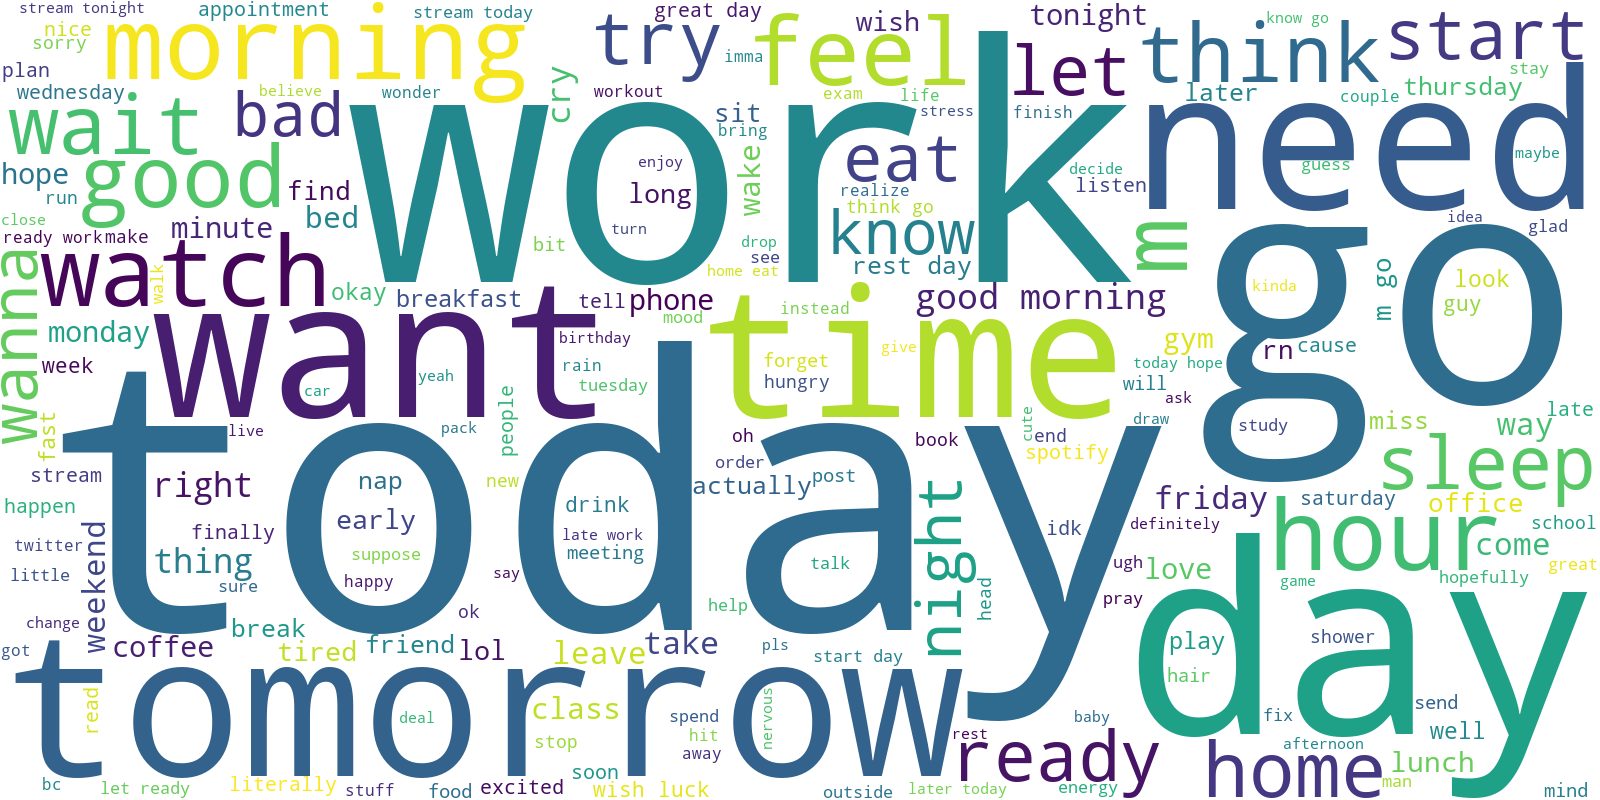

In [23]:
wordcloud_text = " ".join(dataset["context"].map(lambda x: lemmatize(x, nlp)).explode())
# create wordcloud of the tweets
wordcloud = WordCloud(background_color="white", width=1600, height=800).generate(wordcloud_text)
display_wordcloud(wordcloud)

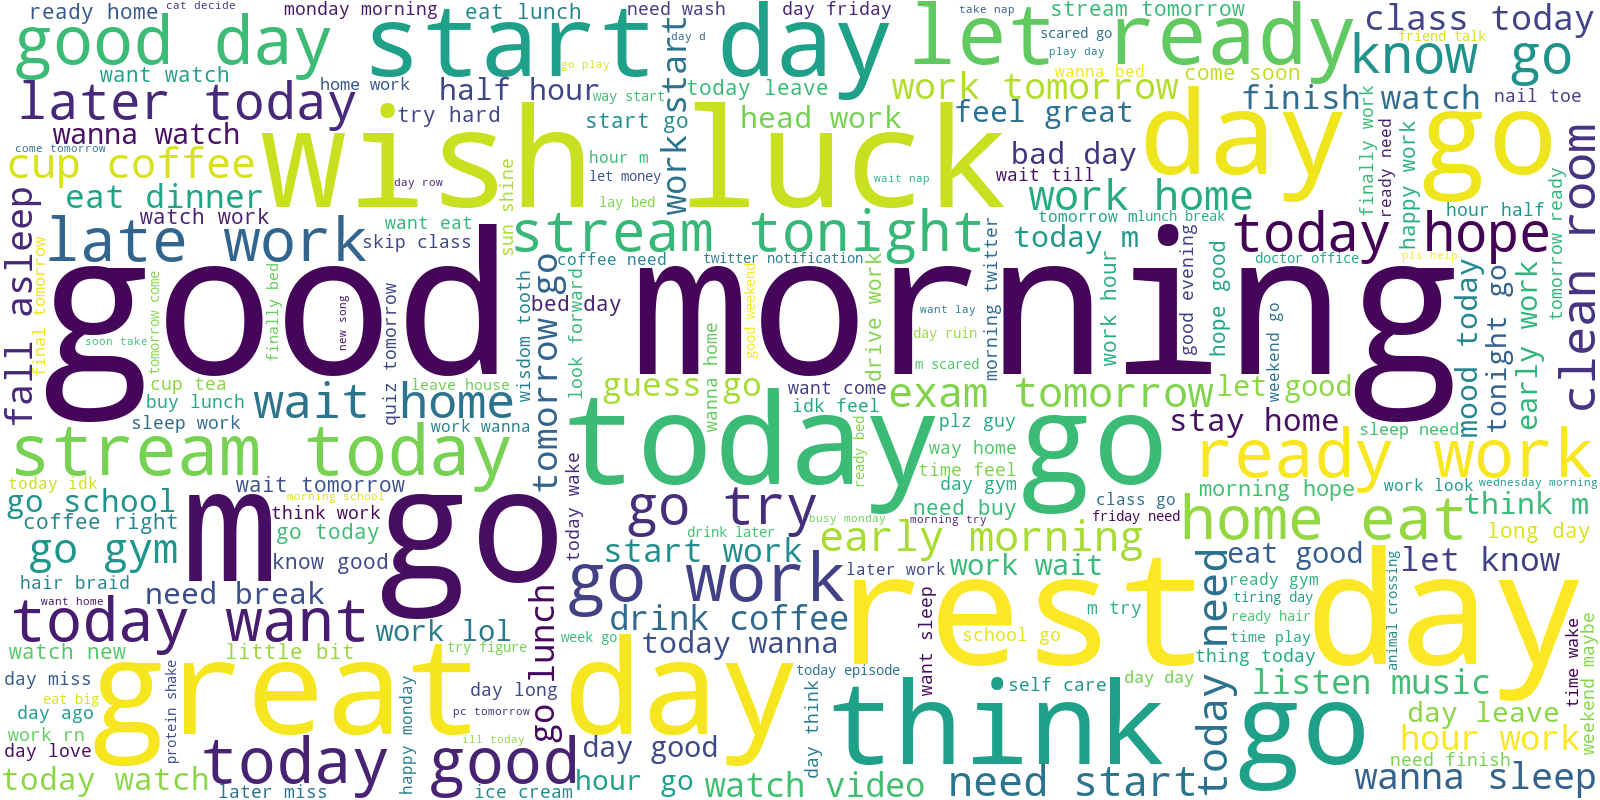

In [24]:
# create wordcloud of bigrams
wordcloud = WordCloud(background_color="white", width=1600, height=800, collocation_threshold=3).generate(wordcloud_text)
display_wordcloud(wordcloud)

We calculate the relative frequency of words between the sets of tweets.

In [25]:
# Calculate keyness values for the increase and decrease tweets
increase_counts = dataset_increased["follow_up"].map(lambda x: lemmatize(x, nlp)).explode().value_counts().to_dict()
decrease_counts = dataset_decreased["follow_up"].map(lambda x: lemmatize(x, nlp)).explode().value_counts().to_dict()
# Calculate keyness values
keyness = calculate_keyness(increase_counts, decrease_counts)
keyness["keyness"] = keyness["keyness"].round(2)
keyness

word  keyness
0         week   244.07
1     tomorrow   168.06
2          day   131.48
3      weekend    75.68
4           go    66.58
..         ...      ...
289    morning   -44.58
290      right   -50.10
291  afternoon   -56.74
292      early   -78.42
293     minute  -109.05

[294 rows x 2 columns]

In [26]:
# Calculate keyness values between neutral and increase/decrease tweets
neutral_counts = dataset_neutral["follow_up"].map(lambda x: lemmatize(x, nlp)).explode().value_counts().to_dict()
alter_counts = {k: increase_counts.get(k, 0) + decrease_counts.get(k, 0) for k in (increase_counts.keys() | decrease_counts.keys())}
# Calculate keyness values
keyness = calculate_keyness(neutral_counts, alter_counts)
keyness["keyness"] = keyness["keyness"].round(2)
keyness

word  keyness
0        love   167.74
1        good   137.88
2        feel   119.07
3        hate    86.50
4        hope    68.24
..        ...      ...
241      long   -43.42
242      hour   -68.04
243  tomorrow   -93.41
244      week  -101.43
245        go  -167.68

[246 rows x 2 columns]

# 5. Content Analysis: Temporal Expressions
We look for the presence and quantity of temporal expressions in each group of tweets.

In [27]:
# Store the temporal expressions of each tweet in a new column
tempexp_target = dataset_decreased["context"].map(lambda text: [ent for ent in nlp(text).ents if ent.label_ in ["DATE", "TIME", "DURATION", "SET", "timexy"]])
tempexp_decreased = dataset_decreased["follow_up"].map(lambda text: [ent for ent in nlp(text).ents if ent.label_ in ["DATE", "TIME", "DURATION", "SET", "timexy"]])
tempexp_neutral = dataset_neutral["follow_up"].map(lambda text: [ent for ent in nlp(text).ents if ent.label_ in ["DATE", "TIME", "DURATION", "SET", "timexy"]])
tempexp_increased = dataset_increased["follow_up"].map(lambda text: [ent for ent in nlp(text).ents if ent.label_ in ["DATE", "TIME", "DURATION", "SET", "timexy"]])

In [28]:
# Show examples of "timexy" temporal expressions (usually resolves to duration spans)
tempexp_increased.map(lambda ents: [x.text for x in ents if x.label_ == "timexy"]).explode().dropna().unique()

array(['2 days', 'two days', '5 years', 'two weeks', 'THREE weeks',
       'Three days', '3 days', 'one day', '30 days', 'four days',
       'two months'], dtype=object)

In [29]:
# Extract the expression type from each temporal expression
tempexp_target_types = tempexp_target.map(lambda ents: ["OTHER" if x.label_ == "timexy" else x.label_ for x in ents])
tempexp_decreased_types = tempexp_decreased.map(lambda ents: ["OTHER" if x.label_ == "timexy" else x.label_ for x in ents])
tempexp_neutral_types = tempexp_neutral.map(lambda ents: ["OTHER" if x.label_ == "timexy" else x.label_ for x in ents])
tempexp_increased_types = tempexp_increased.map(lambda ents: ["OTHER" if x.label_ == "timexy" else x.label_ for x in ents])

In [30]:
# Plot the count of temporal expressions of each type
fig = go.Figure()

fig.add_trace(go.Bar(
    x=tempexp_target_types.explode().value_counts().index,
    y=tempexp_target_types.explode().value_counts().values,
    name='Target Statements',
))

fig.add_trace(go.Bar(
    x=tempexp_decreased_types.explode().value_counts().index,
    y=tempexp_decreased_types.explode().value_counts().values,
    name='Decreased TV Follow-Ups',
))

fig.add_trace(go.Bar(
    x=tempexp_neutral_types.explode().value_counts().index,
    y=tempexp_neutral_types.explode().value_counts().values,
    name='Unchanged TV Follow-Ups'
))

fig.add_trace(go.Bar(
    x=tempexp_increased_types.explode().value_counts().index,
    y=tempexp_increased_types.explode().value_counts().values,
    name='Increased TV Follow-Ups',
))

fig.update_layout(
    title="Count of Temporal Expressions in each Tweet Set",
    xaxis_title="Temporal Expression Type",
    yaxis_title="Count",
    barmode='group',
    width=800,
    height=600,
    template="plotly_white"
)

fig.show()

In [31]:
# Plot the count of tweets that have at least one temporal expression in each type
fig = go.Figure()

fig.add_trace(go.Bar(
    x=tempexp_target_types.map(lambda x: len(x) > 0).value_counts().index,
    y=tempexp_target_types.map(lambda x: len(x) > 0).value_counts().values,
    name='Target Statements',
))

fig.add_trace(go.Bar(
    x=tempexp_decreased_types.map(lambda x: len(x) > 0).value_counts().index,
    y=tempexp_decreased_types.map(lambda x: len(x) > 0).value_counts().values,
    name='Decreased TV Follow-Ups',
))

fig.add_trace(go.Bar(
    x=tempexp_neutral_types.map(lambda x: len(x) > 0).value_counts().index,
    y=tempexp_neutral_types.map(lambda x: len(x) > 0).value_counts().values,
    name='Unchanged TV Follow-Ups'
))

fig.add_trace(go.Bar(
    x=tempexp_increased_types.map(lambda x: len(x) > 0).value_counts().index,
    y=tempexp_increased_types.map(lambda x: len(x) > 0).value_counts().values,
    name='Increased TV Follow-Ups',
))

fig.update_layout(
    title="Count of Tweets with at least one Temporal Expression in each Tweet Set",
    xaxis_title="Contains Temporal Expression",
    yaxis_title="Count",
    barmode='group',
    width=800,
    height=600,
    template="plotly_white",
    xaxis = dict(
        tickmode = 'array',
        tickvals = [0, 1],
        ticktext = ["No Temporal Expressions", "At least one Temporal Expression"]
    )
)

fig.show()